# 1) Data preprocessing

In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler


In [2]:
# Load JSONL file
def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = [json.loads(line) for line in f]
    print(f"Loaded {len(data)} records from {file_path}.")
    return data

In [3]:
# Extract features from the training dataset
def extract_training_data(training_data):
    post_data = []
    profile_data = []

    for item in training_data:
        # Extract profile-level data
        profile = item.get('profile', {})
        profile_id = profile.get('id', 'UNKNOWN')
        username = profile.get('username', 'UNKNOWN')
        post_count = profile.get('post_count', 0)
        follower_count = profile.get('follower_count', 0)
        highlight_reel_count = profile.get('highlight_reel_count', 0)
        
        # Save profile-level data
        profile_data.append({
            'profile_id': profile_id,
            'username': username,
            'post_count': post_count,
            'follower_count': follower_count,
            'highlight_reel_count': highlight_reel_count
        })
        
        # Extract post-level data
        for post in item.get('posts', []):
            post_id = post.get('id', 'UNKNOWN')
            caption = post.get('caption', '')
            like_count = post.get('like_count')
            comments_count = post.get('comments_count', 0)
            media_type = post.get('media_type', 'UNKNOWN')
            
            # Include only if like_count is not missing
            if like_count is not None:
                post_data.append({
                    'post_id': post_id,
                    'caption': caption,
                    'like_count': like_count,
                    'comments_count': comments_count,
                    'media_type': media_type,
                    'profile_id': profile_id  # Link to profile
                })
    
    # Convert to DataFrames
    df_posts = pd.DataFrame(post_data)
    df_profiles = pd.DataFrame(profile_data).drop_duplicates(subset='profile_id')  # Avoid duplicate profiles
    
    # Join profile data to posts based on profile_id
    df_combined = df_posts.merge(df_profiles, on='profile_id', how='left')
    
    print(f"Extracted {len(df_combined)} rows of data after combining posts and profiles.")
    return df_combined

In [4]:
def preprocess_combined_data(df):
    # Ensure no None or NaN values in the 'caption' column
    df['caption'] = df['caption'].fillna('').astype(str)

    # Handle heavy-tailed distributions with log transformation
    df['comments_count_log'] = np.log1p(df['comments_count'])

    # remove like count from training
    y = df['like_count']
    df.drop('like_count', axis=1, inplace=True)

    # Textual feature extraction using TF-IDF for captions
    vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_features = vectorizer.fit_transform(df['caption']).toarray()
    print(f"TF-IDF features shape: {tfidf_features.shape}")

    # Encode media type as a numerical feature
    media_type_mapping = {media: idx for idx, media in enumerate(df['media_type'].unique())}
    df['media_type_encoded'] = df['media_type'].map(media_type_mapping)

    # Feature engineering: followers per post and comments-to-followers ratio
    df['followers_per_post'] = df['follower_count'] / (df['post_count'] + 1)  # Avoid division by zero
    df['comments_to_followers_ratio'] = df['comments_count'] / (df['follower_count'] + 1)

    # Replace infinite values and handle NaNs
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    # Combine features: TF-IDF, comments count, media type, profile-level features, and engineered features
    features = pd.DataFrame(tfidf_features)
    features['comments_count_log'] = df['comments_count_log']
    features['media_type_encoded'] = df['media_type_encoded']
    features['post_count'] = df['post_count']
    features['follower_count'] = df['follower_count']
    features['highlight_reel_count'] = df['highlight_reel_count']
    features['followers_per_post'] = df['followers_per_post']
    features['comments_to_followers_ratio'] = df['comments_to_followers_ratio']

    # Ensure all column names are strings
    features.columns = features.columns.astype(str)
    print("Feature columns:", features.columns)
    
    # Standardize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    print("Features standardized.")

    # Return processed features and target variable
    return features_scaled, np.log1p(y), vectorizer, scaler

In [5]:
# Load and preprocess the training data
training_data_path = 'training-dataset.jsonl'
training_data = load_jsonl(training_data_path)

# Extract and preprocess data
df_combined  = extract_training_data(training_data)
df_combined.head()

Loaded 5415 records from training-dataset.jsonl.
Extracted 183083 rows of data after combining posts and profiles.


,post_id,caption,like_count,comments_count,media_type,profile_id,username,post_count,follower_count,highlight_reel_count
0,17990918969458720,Cumhuriyetimizin 100.yılı kutlu olsun♾️🇹🇷,6.0,0,IMAGE,3170700063,deparmedya,NaN,1167,6
1,18219250732221045,Oriflame Duologi Lansmanı #isveçtengelengüzell...,22.0,1,VIDEO,3170700063,deparmedya,NaN,1167,6
2,18311380465102328,#oriflameilesaçbakımdevrimi ✌️,19.0,0,VIDEO,3170700063,deparmedya,NaN,1167,6
3,18089518138361507,✌️#oriflameilesaçbakımdevrimi 07Agustos’23 ori...,19.0,1,VIDEO,3170700063,deparmedya,NaN,1167,6
4,18012743929758497,07 Agustos’23 #oriflameturkiye #duoloji,21.0,0,VIDEO,3170700063,deparmedya,NaN,1167,6


In [6]:
X, y, tfidf_vectorizer, feature_scaler = preprocess_combined_data(df_combined)

# Save vectorizer and scaler for later use
import pickle
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)

print("Preprocessing complete. Ready for model training!")

TF-IDF features shape: (183083, 1000)
Feature columns: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '997', '998', '999', 'comments_count_log', 'media_type_encoded',
       'post_count', 'follower_count', 'highlight_reel_count',
       'followers_per_post', 'comments_to_followers_ratio'],
      dtype='object', length=1007)
Features standardized.
Preprocessing complete. Ready for model training!


# 2) Exploratory Data Analysis (EDA)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# 1. Summary Statistics
print("Summary Statistics for Numerical Features:")
df_combined.describe()

Summary Statistics for Numerical Features:


,like_count,comments_count,post_count,follower_count,highlight_reel_count,comments_count_log,media_type_encoded,followers_per_post,comments_to_followers_ratio
count,1.830830e+05,183083.000000,183083.000000,1.830830e+05,183083.000000,183083.000000,183083.000000,183083.000000,183083.000000
mean,6.636646e+03,99.464811,173.745787,2.457490e+05,14.758896,1.385436,0.721968,209.895071,0.001048
std,6.368918e+04,2628.552296,1074.272209,1.896221e+06,136.316046,1.861254,0.774530,5079.382708,0.025839
min,0.000000e+00,0.000000,0.000000,1.600000e+01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.200000e+01,0.000000,0.000000,3.411000e+03,3.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000e+01,1.000000,0.000000,1.362300e+04,7.000000,0.693147,1.000000,0.000000,0.000022
75%,3.790000e+02,8.000000,0.000000,6.740300e+04,13.000000,2.197225,1.000000,0.000000,0.000265
max,9.553161e+06,775464.000000,30856.000000,6.324671e+07,9660.000000,13.561218,2.000000,636895.500000,4.035207


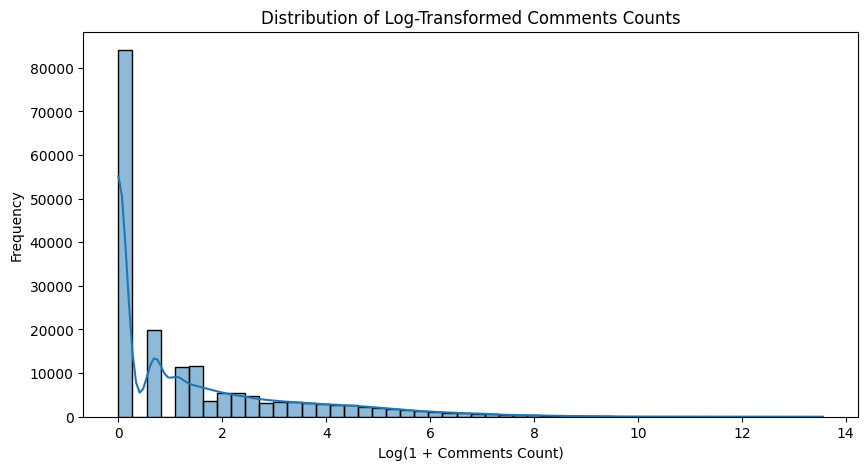

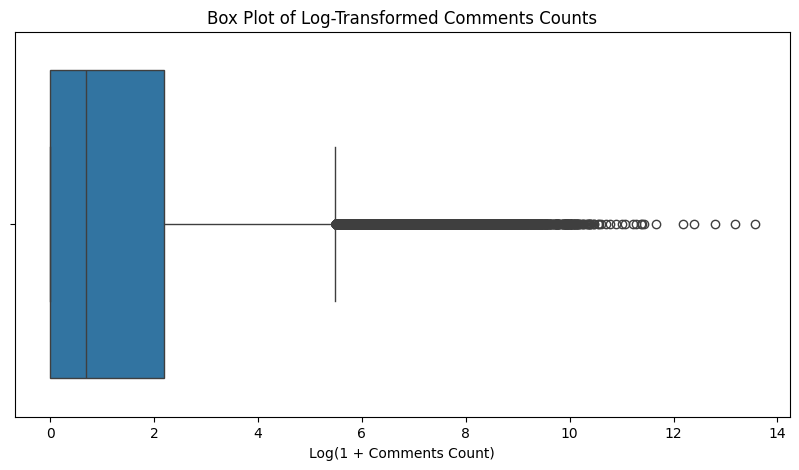

In [9]:
# 2. Distribution of Key Variables (Log-Transformed)
plt.figure(figsize=(10, 5))
sns.histplot(df_combined['comments_count_log'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Comments Counts')
plt.xlabel('Log(1 + Comments Count)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=df_combined['comments_count_log'])
plt.title('Box Plot of Log-Transformed Comments Counts')
plt.xlabel('Log(1 + Comments Count)')
plt.show()

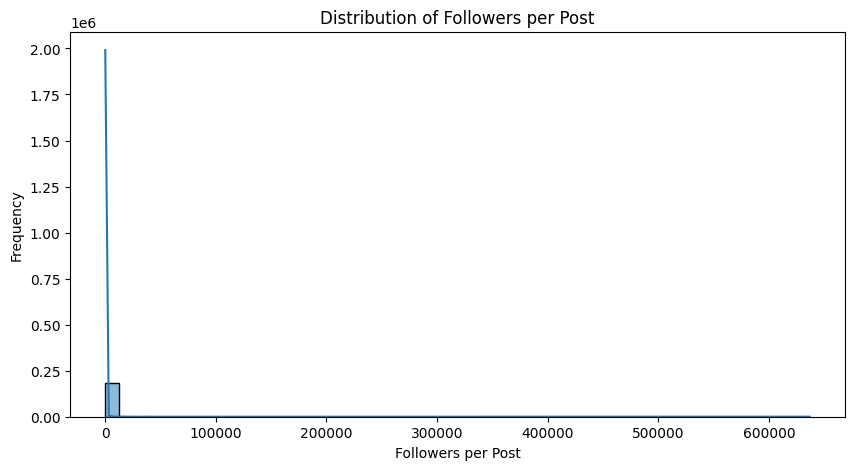

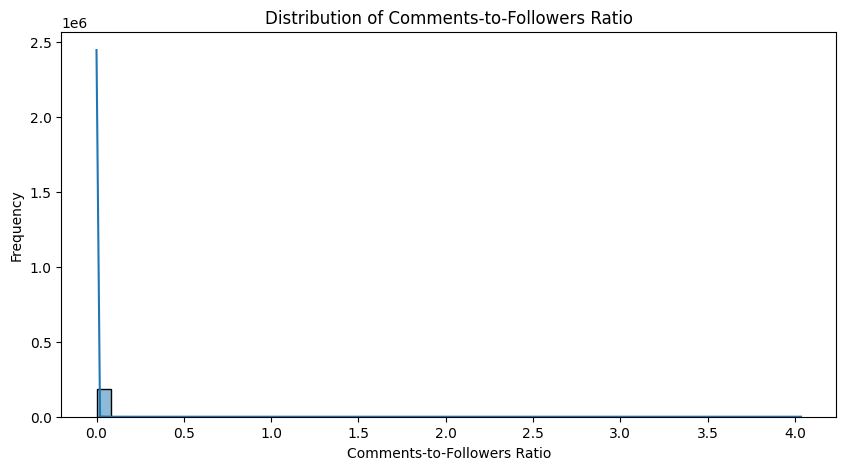

In [10]:
# 3. Distribution of Engineered Features
plt.figure(figsize=(10, 5))
sns.histplot(df_combined['followers_per_post'], bins=50, kde=True)
plt.title('Distribution of Followers per Post')
plt.xlabel('Followers per Post')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df_combined['comments_to_followers_ratio'], bins=50, kde=True)
plt.title('Distribution of Comments-to-Followers Ratio')
plt.xlabel('Comments-to-Followers Ratio')
plt.ylabel('Frequency')
plt.show()

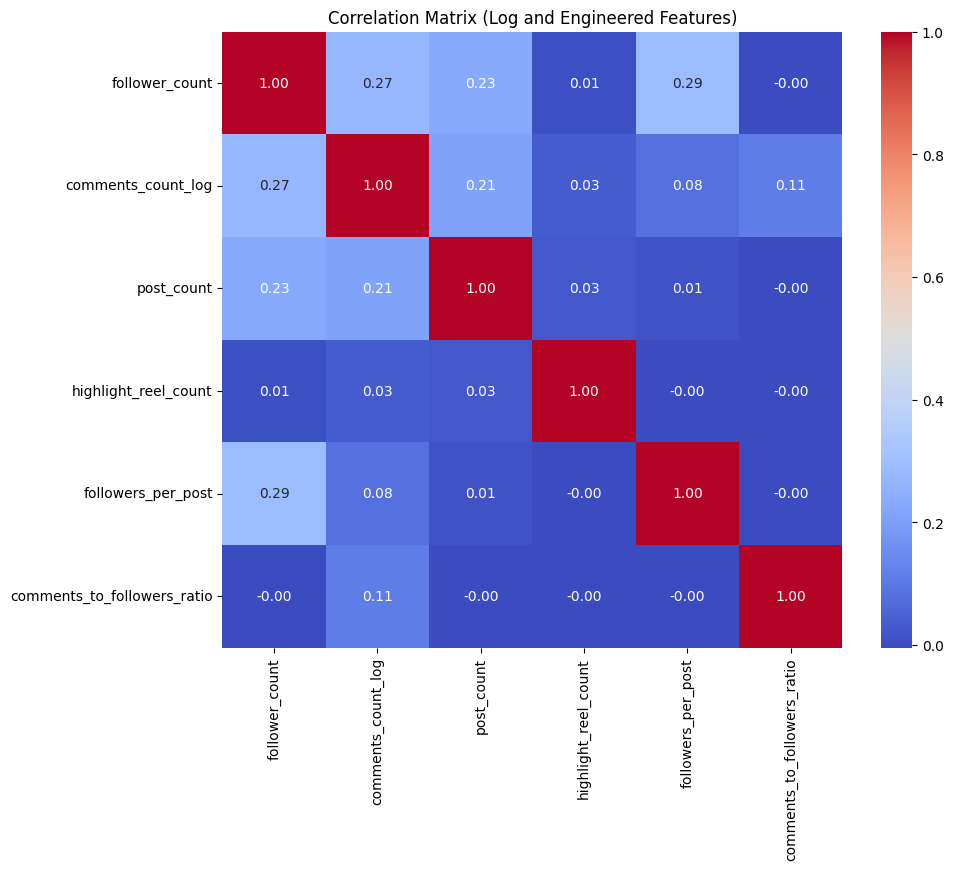

In [11]:
# 4. Correlation Analysis
numeric_features = ['follower_count', 'comments_count_log', 
                    'post_count', 'highlight_reel_count', 
                    'followers_per_post', 'comments_to_followers_ratio']
correlation_matrix = df_combined[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Log and Engineered Features)')
plt.show()

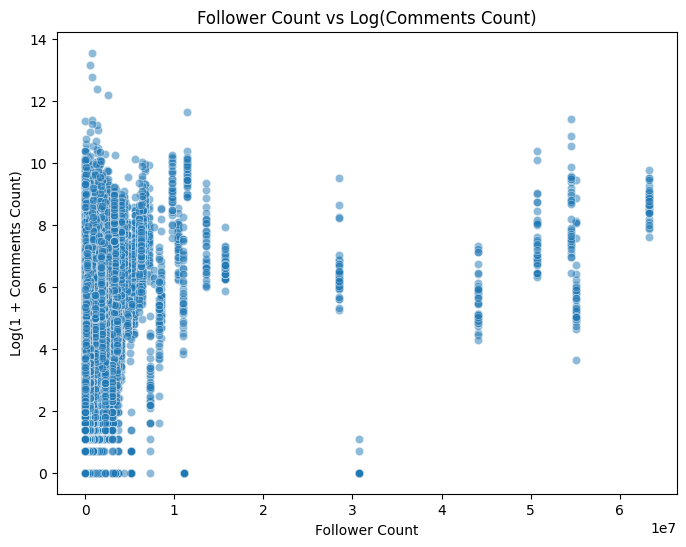

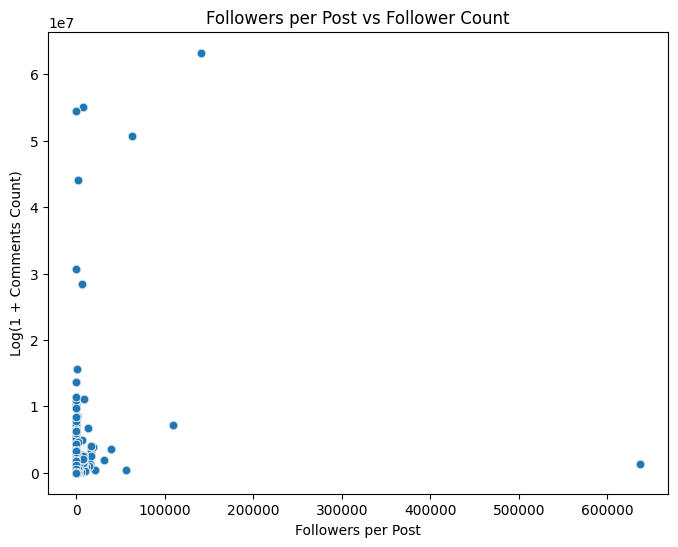

In [12]:
# 5. Scatter Plots for Key Relationships
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_combined['follower_count'], y=df_combined['comments_count_log'], alpha=0.5)
plt.title('Follower Count vs Log(Comments Count)')
plt.xlabel('Follower Count')
plt.ylabel('Log(1 + Comments Count)')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_combined['followers_per_post'], y=df_combined['follower_count'], alpha=0.5)
plt.title('Followers per Post vs Follower Count')
plt.xlabel('Followers per Post')
plt.ylabel('Log(1 + Comments Count)')
plt.show()

# 3) Random Forest Regression

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [14]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Training set shape: (146466, 1007), Test set shape: (36617, 1007)


In [15]:
# Train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_jobs=-1, random_state=42)

In [16]:
# Evaluate the model

y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

# Reverse log transformation for predictions and actual values
y_train_actual = np.expm1(y_train)
y_train_pred_actual = np.expm1(y_train_pred)
y_test_actual = np.expm1(y_test)
y_test_pred_actual = np.expm1(y_test_pred)

# Calculate RMSE in the original scale
train_rmse_original = np.sqrt(mean_squared_error(y_train_actual, y_train_pred_actual))
test_rmse_original = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_actual))

# Calculate R² scores in the original scale
train_r2_original = r2_score(y_train_actual, y_train_pred_actual)
test_r2_original = r2_score(y_test_actual, y_test_pred_actual)

# Print evaluation results in the original scale
print(f"Training RMSE (Original Scale): {train_rmse_original}")
print(f"Testing RMSE (Original Scale): {test_rmse_original}")
print(f"Training R² (Original Scale): {train_r2_original}")
print(f"Testing R² (Original Scale): {test_r2_original}")


Training RMSE (Original Scale): 21847.029410326762
Testing RMSE (Original Scale): 23880.476917300253
Training R² (Original Scale): 0.8945786923721042
Testing R² (Original Scale): 0.7373696416143174


In [17]:
# Save the trained model
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_regressor, f)
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)

print("Model training complete and saved!")

Model training complete and saved!


# test - didnt work after here

In [42]:
def preprocess_test_data_with_missing(input_data, tfidf_vectorizer, feature_scaler, feature_columns, fill_values):
    """
    Preprocesses the test data while ensuring feature names match the training data.
    
    Args:
        input_data (dict): Input JSON object with test data.
        tfidf_vectorizer: Trained TF-IDF vectorizer.
        feature_scaler: Trained feature scaler.
        feature_columns (list): List of feature names used during training.
        fill_values (dict): Default values for numeric features.

    Returns:
        np.array: Scaled feature vector.
    """
    # Extract fields
    caption = input_data.get("caption", "")
    comments_count = input_data.get("comments_count", 0)
    media_type = input_data.get("media_type", "UNKNOWN")
    post_count = input_data.get("post_count", fill_values["post_count"])
    follower_count = input_data.get("follower_count", fill_values["follower_count"])
    highlight_reel_count = input_data.get("highlight_reel_count", fill_values["highlight_reel_count"])
    followers_per_post = input_data.get("followers_per_post", fill_values["followers_per_post"])
    comments_to_followers_ratio = input_data.get("comments_to_followers_ratio", fill_values["comments_to_followers_ratio"])

    # TF-IDF transformation
    caption_tfidf = tfidf_vectorizer.transform([caption]).toarray()
    tfidf_columns = [str(i) for i in range(caption_tfidf.shape[1])]  # Match column names used during training

    # One-hot encode media type
    media_type_mapping = {'CAROUSEL_ALBUM': 0, 'IMAGE': 1, 'VIDEO': 2}
    media_type_onehot = [0] * len(media_type_mapping)  # Default to all zeros
    if media_type in media_type_mapping:
        media_type_onehot[media_type_mapping[media_type]] = 1
    media_type_columns = [f"media_type_{key}" for key in media_type_mapping.keys()]

    # Numeric features
    numeric_features = {
        'comments_count_log': np.log1p(comments_count),
        'post_count': post_count,
        'follower_count': follower_count,
        'highlight_reel_count': highlight_reel_count,
        'followers_per_post': followers_per_post,
        'comments_to_followers_ratio': comments_to_followers_ratio
    }

    # Combine all features into a single DataFrame
    combined_features = pd.DataFrame(
        np.hstack([caption_tfidf, [media_type_onehot], [list(numeric_features.values())]]),
        columns=tfidf_columns + media_type_columns + list(numeric_features.keys())
    )

    # Ensure all columns from training are present
    for col in feature_columns:
        if col not in combined_features:
            combined_features[col] = 0  # Add missing columns with default value 0

    # Reorder columns to match training data
    combined_features = combined_features[feature_columns]

    # Standardize features
    standardized_features = feature_scaler.transform(combined_features)

    return standardized_features


In [37]:
fill_values = {
    "post_count": 173.0,  # Replace with actual mean/median from training
    "follower_count": 245750,
    "highlight_reel_count": 15.0,
    "followers_per_post": 210.0,
    "comments_to_followers_ratio": 0.001
}

In [38]:
df_combined.describe()

,like_count,comments_count,post_count,follower_count,highlight_reel_count,comments_count_log,media_type_encoded,followers_per_post,comments_to_followers_ratio
count,1.830830e+05,183083.000000,183083.000000,1.830830e+05,183083.000000,183083.000000,183083.000000,183083.000000,183083.000000
mean,6.636646e+03,99.464811,173.745787,2.457490e+05,14.758896,1.385436,0.721968,209.895071,0.001048
std,6.368918e+04,2628.552296,1074.272209,1.896221e+06,136.316046,1.861254,0.774530,5079.382708,0.025839
min,0.000000e+00,0.000000,0.000000,1.600000e+01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.200000e+01,0.000000,0.000000,3.411000e+03,3.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000e+01,1.000000,0.000000,1.362300e+04,7.000000,0.693147,1.000000,0.000000,0.000022
75%,3.790000e+02,8.000000,0.000000,6.740300e+04,13.000000,2.197225,1.000000,0.000000,0.000265
max,9.553161e+06,775464.000000,30856.000000,6.324671e+07,9660.000000,13.561218,2.000000,636895.500000,4.035207


In [44]:
# Process JSONL file and predict
input_file = "test-regression-round1.jsonl"
output_file = "prediction-regression-round1.json"

predictions = {}

with open(input_file, 'r') as infile:
    for line in infile:
        data = json.loads(line.strip())
        post_id = data.get("id")  # Extract post ID
        if not post_id:
            continue
        
        feature_columns = [
        *[str(i) for i in range(1000)],  # TF-IDF features
        "media_type_CAROUSEL_ALBUM", "media_type_IMAGE", "media_type_VIDEO",
        "comments_count_log", "post_count", "follower_count", "highlight_reel_count",
        "followers_per_post", "comments_to_followers_ratio"
            ]

        # Preprocess the data
        preprocessed_data = preprocess_test_data_with_missing(
            data, tfidf_vectorizer, feature_scaler, feature_columns, fill_values
        )

        # Predict like count
        predicted_like_count = rf_regressor.predict(preprocessed_data)[0]

        # Add to results
        predictions[post_id] = round(predicted_like_count, 2)  # Round to 2 decimal places

# Save predictions to output file
with open(output_file, 'w') as outfile:
    json.dump(predictions, outfile, indent=4)

print(f"Predictions saved to {output_file}")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- media_type_CAROUSEL_ALBUM
- media_type_IMAGE
- media_type_VIDEO
Feature names seen at fit time, yet now missing:
- media_type_encoded


DIDNT WORK